<a href="https://colab.research.google.com/github/ashikshafi08/Learning_Tensorflow/blob/main/Experiments/Copy_of_AI_Crowd_Research_paper_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install aicrowd-cli
API_KEY = '' 
!aicrowd login --api-key $API_KEY

# Downloading the Dataset
# Downloading the Dataset ( removing data and assets folder if existing already and then creating the folder )
!rm -rf data
!mkdir data
!rm -rf assets
!mkdir assets

!aicrowd dataset download --challenge research-paper-classification -j 3 -o data # Downloading the dataset and saving it in data folder

     |████████████████████████████████| 51kB 5.4MB/s 
     |████████████████████████████████| 174kB 21.0MB/s 
     |████████████████████████████████| 81kB 4.8MB/s 
     |████████████████████████████████| 61kB 6.1MB/s 
     |████████████████████████████████| 215kB 33.6MB/s 
     |████████████████████████████████| 61kB 6.4MB/s 
     |████████████████████████████████| 71kB 8.0MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
API Key valid
Saved API Key successfully!
train.csv:   0% 0.00/8.77M [00:00<?, ?B/s]
test.csv:  

In [ ]:
# Importing all the packages we need 
import tensorflow as tf 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Importing the data 

train_data = pd.read_csv('data/train.csv')
val_data = pd.read_csv('data/val.csv')
test_data = pd.read_csv('data/test.csv')

# Printing out all shapes of our data 
print(f'Shape of the train data: {train_data.shape}')
print(f'Shape of the validation data: {val_data.shape}')
print(f'Shape of the test data: {test_data.shape}')

Shape of the train data: (31500, 3)
Shape of the validation data: (2700, 3)
Shape of the test data: (10800, 3)


In [ ]:
train_data.head()

,id,text,label
0,0,we propose deep network models and learning al...,3
1,1,multi-distance information computed by the MDL...,3
2,2,traditional solutions consider dense pedestria...,2
3,3,"in this paper, is used the lagrangian classica...",2
4,4,the aim of this work is to determine how vulne...,3


In [ ]:
# How many labels are there? 
train_data['label'].value_counts()

3    19676
0     4352
1     4078
2     3394
Name: label, dtype: int64

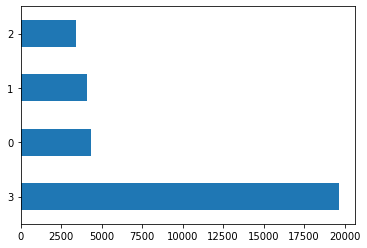

In [ ]:
# Plotting the above same stuff 
train_data['label'].value_counts().plot(kind = 'barh')

In [ ]:
# Shuffling our train data 
train_data_shuffled = train_data.sample(frac = 1 , random_state = 42)
train_data_shuffled.head() , train_data_shuffled.shape

(          id                                               text  label
 14664  14664  DefGrid is a learnable neural network module t...      3
 1981    1981  combining Haar-Hilbert and Log-Gabor improves ...      3
 18349  18349  the simulator, based on ROS (Robot Operating S...      2
 20489  20489  we propose a method to synthesize policies tha...      0
 18121  18121  previous flow completion methods are often una...      3,
 (31500, 3))

In [ ]:
# Splitting sentences and labels
train_sentences = train_data_shuffled['text'].to_numpy()
train_labels = train_data_shuffled['label'].to_numpy()

val_sentences = val_data['text'].to_numpy()
val_labels = val_data['label'].to_numpy()

test_sentences = test_data['text'].to_numpy()
test_labels = test_data['label'].to_numpy()


# Checking the shapes 
print(f'Shape of the train sentences: {train_sentences.shape}')
print(f'Shape of the validation sentences: {val_sentences.shape}')
print(f'Shape of the train labels: {train_labels.shape}')
print(f'Shape of the validation labels: {val_labels.shape}')

Shape of the train sentences: (31500,)
Shape of the validation sentences: (2700,)
Shape of the train labels: (31500,)
Shape of the validation labels: (2700,)


In [ ]:
# Converting into dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences , train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences , val_labels))


In [ ]:
train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
# Enabling prefetch and turning our data into batches.

train_dataset = train_dataset.shuffle(buffer_size= 1000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size = 32).prefetch(tf.data.AUTOTUNE)


In [ ]:
train_dataset , val_dataset

(<PrefetchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int64)>,
 <PrefetchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int64)>)

In [ ]:
import numpy as np 
zero , one , two , three = np.bincount(train_data['label'])
total = zero + one + two + three
print(f'Examples:\n Total:{total}\n\n  Zero:{zero} ({100 * zero / total:.2f}% of total)\n  One:{one}  ({100 * one / total:.2f}% of total)\n  Two:{two}  ({100 * two / total:.2f}% of total)\n  Three:{three} ({100 * three / total:.2f}% of total)\n')


Examples:
 Total:31500

  Zero:4352 (13.82% of total)
  One:4078  (12.95% of total)
  Two:3394  (10.77% of total)
  Three:19676 (62.46% of total)



In [ ]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [ ]:
# Calculating the class weights for each labels
weight_for_0 = (1 / zero) * (total / 2.0)
weight_for_1 = (1 / one) * (total / 2.0)
weight_for_2 = (1 / two) * (total / 2.0)
weight_for_3 = (1 / three) * (total / 2.0)

# Creating a dictionary of class weights
class_weight = {0: weight_for_0 , 
                1: weight_for_1 , 
                2: weight_for_2 , 
                3: weight_for_3}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))
print('Weight for class 3: {:.2f}'.format(weight_for_3))




Weight for class 0: 3.62
Weight for class 1: 3.86
Weight for class 2: 4.64
Weight for class 3: 0.80


In [ ]:
np.unique(train_labels)

array([0, 1, 2, 3])

In [ ]:
zero_train_labels = train_labels == 0
one_train_labels = train_labels == 1
two_train_labels = train_labels == 2
three_train_labels = train_labels == 3

In [ ]:
zero_label_features = train_sentences[zero_train_labels]
one_label_features = train_sentences[one_train_labels]
two_label_features = train_sentences[two_train_labels]
three_label_features = train_sentences[three_train_labels]

len(zero_label_features) , len(one_label_features) , len(two_label_features) , len(three_label_features)

(4352, 4078, 3394, 19676)

In [ ]:
# Checking again
print(f'Examples:\n Total:{total}\n\n  Zero:{zero} ({100 * zero / total:.2f}% of total)\n  One:{one}  ({100 * one / total:.2f}% of total)\n  Two:{two}  ({100 * two / total:.2f}% of total)\n  Three:{three} ({100 * three / total:.2f}% of total)\n')


Examples:
 Total:31500

  Zero:4352 (13.82% of total)
  One:4078  (12.95% of total)
  Two:3394  (10.77% of total)
  Three:19676 (62.46% of total)



In [ ]:
# Now doing the same for labels 
zero_labels = train_labels[zero_train_labels]
one_labels = train_labels[one_train_labels]
two_labels = train_labels[two_train_labels]
three_labels = train_labels[three_train_labels]

len(zero_labels) , len(one_labels) , len(two_labels) , len(three_labels)

(4352, 4078, 3394, 19676)

Using `tf.data`

Balancing the examples using the Dataset api 

In [ ]:
BUFFER_SIZE = 100000

def make_ds(features , labels):
  ds = tf.data.Dataset.from_tensor_slices((features , labels))
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

In [ ]:
zero_ds = make_ds(zero_label_features , zero_labels)
one_ds = make_ds(one_label_features , one_labels)
two_ds = make_ds(two_label_features , two_labels)
three_ds = make_ds(three_label_features , three_labels)

zero_ds , one_ds , two_ds , three_ds

(<RepeatDataset shapes: ((), ()), types: (tf.string, tf.int64)>,
 <RepeatDataset shapes: ((), ()), types: (tf.string, tf.int64)>,
 <RepeatDataset shapes: ((), ()), types: (tf.string, tf.int64)>,
 <RepeatDataset shapes: ((), ()), types: (tf.string, tf.int64)>)

In [ ]:
# Merging all the datasets using (sample_from_datasets) 
BATCH_SIZE = 32
resampled_train_ds = tf.data.experimental.sample_from_datasets([zero_ds , one_ds , two_ds , three_ds] , weights = [0.25 , 0.25 , 0.25 , 0.25])
resampled_train_ds = resampled_train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

resampled_train_ds

<PrefetchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int64)>

In [ ]:
for features, label in resampled_train_ds.take(1):
  print(label.numpy().mean())

1.1875


In [ ]:
for text , label in train_dataset.take(1):
  print(f'Label: {label[0]}')
  print(f'\nText:\n {text[0]}')

Label: 2

Text:
 b'millimeter wave radar is becoming increasingly popular as a sensing modality for robotic mapping and state estimation . but there are very few publicly available datasets that include dense, high-resolution radar scans and none focused on 3D odometry and mapping .'


In [ ]:
# Setting up our text vectorization variable 
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
max_vocab_length = 10000 
max_length = 15

# Creating a instance 
text_vectorizer = TextVectorization(max_tokens = max_vocab_length ,
                                    output_mode = 'int' , 
                                    output_sequence_length = max_length)


In [ ]:
# Fit the text vectorizer to the training sentence
text_vectorizer.adapt(train_sentences)

In [ ]:
# Creating a embedding layer 
from tensorflow.keras import layers 

embedding = layers.Embedding(input_dim = max_vocab_length , 
                             output_dim = 128 , 
                             input_length = max_length)

embedding

In [ ]:
steps_per_epoch = len(train_dataset) // BATCH_SIZE
steps_per_epoch

30

In [ ]:
def scheduler(epoch, lr):
  if epoch < 2:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
# Building an LSTM Model 
from tensorflow.keras import layers 

# Setting up the inputs 
inputs = layers.Input(shape = (1,), dtype = tf.string)

# Converting text into numbers and creating a embedding 
x = text_vectorizer(inputs)
x = embedding(x)

# The LSTM model 
#x = layers.Bidirectional(layers.LSTM(64 , return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
#x = layers.LSTM(32 , return_sequences= True)(x)
#x = layers.LSTM(8)(x)
x = layers.Dense(32 , activation = 'relu')(x)
#x = layers.Dropout(0.1)(x)
# Intializing our outputs 
outputs = layers.Dense(4 , activation= 'softmax')(x)

# Packing into a model 
lstm_model = tf.keras.Model(inputs , outputs , name = 'LSTM_model')

# Summary of the model 
lstm_model.summary()

Model: "LSTM_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_2 (TextVe (None, 15)                0         
_________________________________________________________________
embedding_1 (Embedding)      multiple                  1280000   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_41 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_42 (Dense)             (None, 4)                 132       
Total params: 1,383,076
Trainable params: 1,383,076
Non-trainable params: 0
______________________________________________

In [ ]:
# Compiling the model 
lstm_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy() , 
                   optimizer = tf.keras.optimizers.Adam() , 
                   metrics = ['accuracy'])

In [ ]:
# Fitting the model 
lstm_history = lstm_model.fit(resampled_train_ds , 
                              steps_per_epoch = 350 ,
                              validation_data = val_dataset , 
                              epochs = 6, 
                              class_weight = class_weight)

Epoch 1/6
350/350 [==============================] - 52s 44ms/step - loss: 0.7087 - accuracy: 0.8884 - val_loss: 1.2195 - val_accuracy: 0.6607
Epoch 2/6
350/350 [==============================] - 14s 41ms/step - loss: 0.2316 - accuracy: 0.9538 - val_loss: 1.4801 - val_accuracy: 0.6844
Epoch 3/6
350/350 [==============================] - 14s 41ms/step - loss: 0.1636 - accuracy: 0.9634 - val_loss: 1.5850 - val_accuracy: 0.6933
Epoch 4/6
350/350 [==============================] - 14s 41ms/step - loss: 0.1411 - accuracy: 0.9688 - val_loss: 1.4555 - val_accuracy: 0.7185
Epoch 5/6
350/350 [==============================] - 15s 42ms/step - loss: 0.1432 - accuracy: 0.9682 - val_loss: 1.6042 - val_accuracy: 0.7211
Epoch 6/6
350/350 [==============================] - 14s 41ms/step - loss: 0.1135 - accuracy: 0.9735 - val_loss: 1.6443 - val_accuracy: 0.7156


In [ ]:
lstm_pred_probs = lstm_model.predict(test_sentences)
lstm_preds = np.argmax(lstm_pred_probs , axis =1)
lstm_preds[:10]

array([3, 2, 3, 3, 3, 1, 1, 1, 3, 3])

In [ ]:
lstm_pred_probs = lstm_model.predict(val_sentences)
lstm_preds = np.argmax(lstm_pred_probs , axis =1)
lstm_preds[:10]

array([0, 3, 3, 1, 3, 3, 3, 0, 3, 2])

In [ ]:
def classification_evaluation_metrics(y_true , 
                                      y_preds):
  '''
  Arguments: 
  y_true --> true labels of the data 
  y_preds --> predicted labels of the data 

  Returns: 
  A dictionary of evaluation metrics like precision , recall and f1_score
  '''

  # Let's first import the needed metrics 
  from sklearn.metrics import precision_score , f1_score , accuracy_score , recall_score

  # Creting the metrics 
  accuracy = accuracy_score(y_true , y_preds)
  f1_score = f1_score(y_true , y_preds , average = 'weighted')
  precision = precision_score(y_true , y_preds , average = 'weighted')
  recall = recall_score(y_true , y_preds , average = 'weighted')

  # Now will create a dictionary of these metrics and pack them
  evaluation_dict = {'Accuracy:': accuracy * 100 , 
                     'F1_Score: ': f1_score , 
                     'Precision: ': precision , 
                     'Recall: ': recall }

  # Return our dictionary 
  return evaluation_dict

In [ ]:
# Using the above function 
lstm_results = classification_evaluation_metrics(val_labels , 
                                                    lstm_preds)

# Looking into the dictionary of evaluation metrics 
lstm_results

{'Accuracy:': 71.18518518518519,
 'F1_Score: ': 0.7222431410310249,
 'Precision: ': 0.7391961881455207,
 'Recall: ': 0.7118518518518518}

In [ ]:
# Dropping the label column
test_data.drop('label' , inplace = True , axis = 1)

# Assigning the predictions
test_data['label'] = lstm_preds
test_data.head()


,id,text,label
0,0,we propose a lightweight framework to detect i...,3
1,1,the proposed method presents an alternate solu...,2
2,2,proposed ear identification method fusing SIFT...,3
3,3,a method to reconstruct the three-dimensional ...,3
4,4,strong local consistencies can improve their p...,3


In [ ]:
test_data.to_csv('submission.csv' , index = False)

### Using Transfer Learning 

In [ ]:
# Creating a Keras layer 
import tensorflow_hub as hub
sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4' , 
                                        input_shape = [] , # Defining a input shape so our layer will take anything sequence as a input (any variable length)
                                        dtype = tf.string , 
                                        trainable = False , 
                                        name = 'USE_layer')

In [ ]:
len(train_dataset)

985

In [ ]:
#!pip install tensorflow_addons
import tensorflow_addons as tfa 

f1_score = tfa.metrics.F1Score( num_classes= 3, average = 'weighted')

In [ ]:
# Building a model
from tensorflow.keras import layers

use_model = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(64 , activation = 'relu'),
  #layers.Dense(64 , activation= 'relu'),
  #layers.Dropout(0.1),
  layers.Dense(4 , activation = 'softmax')

] , name = 'USE_model')

# Summary of the mdoel 
use_model.summary()

Model: "USE_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE_layer (KerasLayer)       (None, 512)               256797824 
_________________________________________________________________
dense_21 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_22 (Dense)             (None, 4)                 260       
Total params: 256,830,916
Trainable params: 33,092
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Compiling the model 
use_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy() , 
                  optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001) , 
                  metrics = ['accuracy'])

# Fitting the model 
use_history = use_model.fit(resampled_train_ds ,
                            steps_per_epoch = 250 ,  
                            validation_data = val_dataset , 
                            epochs = 10)

Epoch 1/10
250/250 [==============================] - 8s 24ms/step - loss: 1.3309 - accuracy: 0.5129 - val_loss: 1.2346 - val_accuracy: 0.6904
Epoch 2/10
250/250 [==============================] - 5s 20ms/step - loss: 1.1689 - accuracy: 0.6634 - val_loss: 1.0590 - val_accuracy: 0.7252
Epoch 3/10
250/250 [==============================] - 5s 19ms/step - loss: 1.0155 - accuracy: 0.7007 - val_loss: 0.9609 - val_accuracy: 0.7059
Epoch 4/10
250/250 [==============================] - 5s 19ms/step - loss: 0.9103 - accuracy: 0.7084 - val_loss: 0.8601 - val_accuracy: 0.7141
Epoch 5/10
250/250 [==============================] - 5s 20ms/step - loss: 0.8413 - accuracy: 0.7140 - val_loss: 0.7935 - val_accuracy: 0.7270
Epoch 6/10
250/250 [==============================] - 5s 19ms/step - loss: 0.7971 - accuracy: 0.7172 - val_loss: 0.7590 - val_accuracy: 0.7278
Epoch 7/10
250/250 [==============================] - 5s 20ms/step - loss: 0.7669 - accuracy: 0.7197 - val_loss: 0.7239 - val_accuracy: 0.7370

In [ ]:
use_pred_probs = use_model.predict(test_sentences)
use_preds = np.argmax(use_pred_probs , axis =1)
use_preds[:10]

array([3, 2, 3, 3, 0, 1, 3, 1, 0, 3])

In [ ]:
import tensorflow_hub as hub
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2",
                           input_shape=[], dtype=tf.string)

model = keras.Sequential()
model.add(hub_layer)
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

In [ ]:
# Creating a Keras Layer 
token_based_layer = hub.KerasLayer(
    'https://tfhub.dev/google/nnlm-en-dim128/2' , 
    input_shape = [] , dtype = tf.string
)

# Building a model out of it 
token_based_model = tf.keras.Sequential([                                        
  embedding ,                                          
  token_based_layer ,  
  #layers.Dense(64 , activation = 'tanh')
  layers.Dense(64 , activation = 'relu'),
  layers.Dropout(0.2), 
  layers.Dense(4 , activation = 'softmax')
] , name = 'token_based_model_from_tfhub')

#token_based_model.summary()

# Compile the model 
token_based_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy() , 
                          optimizer = tf.keras.optimizers.Adam() , 
                          metrics = ['accuracy'])

# Fit the model 
token_based_model.fit(resampled_train_ds , 
                      steps_per_epoch = 350 , 
                      validation_data = val_dataset , 
                      epochs = 10)

ValueError: ignored

In [ ]:
# Dropping the label column
test_data.drop('label' , inplace = True , axis = 1)

# Assigning the predictions
test_data['label'] = use_preds
test_data.head()


,id,text,label
0,0,we propose a lightweight framework to detect i...,3
1,1,the proposed method presents an alternate solu...,2
2,2,proposed ear identification method fusing SIFT...,3
3,3,a method to reconstruct the three-dimensional ...,3
4,4,strong local consistencies can improve their p...,0


In [ ]:
import os
#!mkdir assets
test_data.to_csv(os.path.join("assets", "submission.csv"), index=False)

In [ ]:
!aicrowd notebook submit -c research-paper-classification -a assets --no-verify

Using notebook: /content/drive/MyDrive/Colab Notebooks/Copy of AI_Crowd_Research_paper_classification.ipynb for submission...
Removing existing files from submission directory...
Scrubbing API keys from the notebook...
submission.zip ━━━━━━━━━━━━━━━━━━━━━━━━ 100.0% • 1.1/1.1 MB • 1.7 MB/s • 0:00:00
                                                        ╭─────────────────────────╮                                                        
                                                        │ Successfully submitted! │                                                        
                                                        ╰─────────────────────────╯                                                        
                                                              Important links                                                              
┌──────────────────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
